This is a notebook to recreate Figure 1 of Lamb, Taylor & Siemens 2023.  This notebook compares the free spectrum and posterior contours of the full-likelihood uncorrelated analysis, PTA free spectrum refit, GFL Lite, and GFL analyses.

In [20]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import numpy as np
import matplotlib.pyplot as plt
import glob
from chainconsumer import ChainConsumer
import pickle
from ceffyl import Ceffyl, models
from enterprise.signals import parameter, gp_priors as gpp
from enterprise_extensions.model_utils import get_tspan
import la_forge.core as co
from scipy.stats import rv_histogram
import seaborn as sns

# ACCRE-specific import to load correct latex file
## COMMENT OUT AS REQUIRED
import os
os.environ["PATH"] += os.pathsep + '/home/lambwg/latex/bin/x86_64-linux' 

In [21]:
# setup default plotting code
plt.rcParams.update(plt.rcParamsDefault)
with open('/home/lambwg/ng15_rcparams.json', 'rb') as fin:
    plt.rcParams.update(json.load(fin))

In [22]:
plt.rcParams["figure.figsize"] = [3.5503666805036667*2, 2.1942472810764047]

# Run the analyses!

Find example scripts to analyse the full uncorrelated likelihood, PTA free spectrum, and single pulsar free spectra [here](./scripts). Find tutorials to convert free spectrum into KDEs, and refitting examples [here](../). These examples also show you how to check for convergence, good sampling etc.

# Plot! 

In [6]:
pars = ['gamma_gw', 'log10_A_gw']  # params to plot
inj = np.loadtxt(f'../../data/sim51/injected_values.txt')  # load inj values

# free spectrum refit
chaindir = f'/data/taylor_group/william_lamb/GFL/middleton21/freespec10f/realisation_51/fftkde_10k_2/refits/10fplCP/'
fs10f = co.Core(corepath=chaindir+'chain.core')

# GFL Lite analysis
chaindir = f'/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/fftkde_10000_final/refits/10fplCP/'
gl10f = co.Core(corepath=chaindir+'chain.core')

# GFL analysis
#chaindir = f'/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP/realisation_51/fftkde_10000_final/'
#gfl10f = co.Core(corepath=chaindir+'chain.core')

# full likelihood analysis
chaindir = f'/data/taylor_group/william_lamb/GFL/middleton21/m2a_10f/realisation_51/'
m2a10f = co.Core(corepath=chaindir+'chain.core')

# PTA free spectrum
chaindir = f'/data/taylor_group/william_lamb/GFL/middleton21/freespec10f/realisation_51/chain.core'
freespec = co.Core(corepath=chaindir)

In [7]:
Tspan = 477171786.6243229
freqs = np.arange(1,11)/Tspan

In [8]:
pl = gpp.powerlaw(freqs, log10_A=inj[0], gamma=inj[1], components=1)

In [10]:
# collecting samples from GFL Lite
# -------
# plotting violin plots
rho_labels = [f'log10_rho_{ii}' for ii in range(10)]
rho_bins = np.linspace(-9.5, -6., num=50) # rho bins
drho = rho_bins[1]-rho_bins[0]

# turning freespec into rv hist and sampling
epsilon = 1e-250  # make histograms for each rho
histograms = np.array([np.histogram(freespec(rho), bins='fd', density=True)
                       for rho in rho_labels])

rvhist = [rv_histogram(hist) for hist in histograms]

# draw samples from histograms for each rho
rv_samples = [rvh.rvs(size=100000) for rvh in rvhist]

# do the same for single pulsars
# multiply histograms of each psr for each rho. Save to dict corresponding to each rho
epsilon = 1e-20
s_hists = []
for ii in range(45):
    spsr = co.Core(corepath=f'/data/taylor_group/william_lamb/GFL/middleton21/spsrs_10fCP_10firn/realisation_51/psr_{ii}/chain.core'
                  )
    s_hists.append([np.histogram(spsr(rho), density=True,
                                 bins=rho_bins)[0]+epsilon
                    for rho in rho_labels])
s_hists = np.array(s_hists)

hist_prod = np.prod(s_hists, axis=0)
hist_prod /= (hist_prod.sum(axis=1)[:,None]*drho)  # normalise!

rvhist = [rv_histogram([hist_prod[ii], rho_bins])
                for ii in range(10)]

srv_samples = [rvhist[ii].rvs(size=1000)
               for ii in range(10)]

/tmp/ipykernel_104720/2713714729.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  histograms = np.array([np.histogram(freespec(rho), bins='fd', density=True)


In [14]:
colour = sns.color_palette('colorblind', as_cmap=True)

In [38]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

fig, (ax1, ax2) = plt.subplots(ncols=2, tight_layout=True)

v1 = ax1.violinplot(rv_samples, positions=np.log10(freqs), widths=0.1)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes',):
    vp = v1[partname]
    vp.set_edgecolor(colour[2])
    vp.set_linestyle((0,(5,1)))
    vp.set_linewidth(1)
# Make the violin body blue with a red border:
for vp in v1['bodies']:
    vp.set_facecolor('white')
    vp.set_edgecolor(colour[2])
    vp.set_linewidth(1)
    vp.set_linestyle((0,(5,1)))
    vp.set_alpha(1)
    m = np.mean(vp.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    vp.get_paths()[0].vertices[:, 0] = np.clip(vp.get_paths()[0].vertices[:, 0], -np.inf, m)
    #vp.set_color('C3')

v2 = ax1.violinplot(srv_samples, positions=np.log10(freqs), widths=0.1)
# Make all the violin statistics marks red:
for partname in ('cbars','cmins','cmaxes',):
    vp = v2[partname]
    vp.set_edgecolor(colour[0])
    #vp.set_linewidth(2)
# Make the violin body blue with a red border:
for vp in v2['bodies']:
    vp.set_facecolor(colour[0])
    vp.set_edgecolor(colour[0])
    #vp.set_linewidth(2)
    vp.set_alpha(0.5)
    m = np.mean(vp.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    vp.get_paths()[0].vertices[:, 0] = np.clip(vp.get_paths()[0].vertices[:, 0], m, np.inf)
    vp.set_color(colour[0])

ax1.set_ylim(-9)
ax1.plot(np.log10(freqs), 0.5*np.log10(pl), lw=1,
         c='k', label='injected', alpha=0.5, ls='--')

plp = Line2D([0], [0], label='injected', color='k', alpha=0.5, ls='--')
fs = mpatches.Patch(label='PTA free spectrum', color=colour[0], alpha=0.5)
gl = mpatches.Patch(label='GFL Lite', edgecolor=colour[2],
                    facecolor='white', linestyle='-.')
ax1.legend(handles=[fs, gl, plp])

ax1.set_xlabel(r'$\log_{10}$ [GW frequency (Hz)]')#, fontsize=12)
ax1.set_ylabel(r'$\log_{10}$ [CP delay (s)]')#, fontsize=12)

c = ChainConsumer()
c.add_chain(fs10f(pars), name=f'free spectrum refit', shade_alpha=0, linestyle='--',
            parameters=[r'$\gamma$', r'$\log_{10}A_\mathrm{CP}$'], color=colour[0])
c.add_chain(gl10f(pars), name=f'GFL Lite', color=colour[2],
            linestyle='-.', shade_alpha=0)
#c.add_chain(gfl10f(pars), name=f'GFL', shade_alpha=1,
#            linestyle=':')#, color=colour[2])
c.add_chain(m2a10f(pars), name=f'full likelihood', shade_alpha=0,
            color=colour[1], linestyle='-')
c.configure(usetex=True, sigmas=[1,2], smooth=False, shade_gradient=[0,0,0],
            linewidths=1, legend_kwargs={"loc": "lower left",
                                         "frameon":False},
            diagonal_tick_labels=False,)# tick_font_size=12)
corner = c.plotter.plot_contour(ax2, r'$\gamma$', r'$\log_{10}A_\mathrm{CP}$');
               #extents=[(3, 4.6), (-14.9, -14.15)]);

ax2.set_xlabel(r'Spectral index $\gamma=3-2\alpha$')#, fontsize=12)
ax2.set_ylabel(r'$\log_{10} A_{1{\mathrm{yr}}^{-1}}$')#, fontsize=12)
ax2.axhline(inj[0], c='k', ls='--', alpha=0.5, lw=1)
ax2.axvline(inj[1], c='k', ls='--', alpha=0.5, lw=1)
ax2.set(xlim=(3., 4.6), ylim=(-14.85, -14.2))

c1 = mpatches.Patch(label='free spectrum refit', fill=False,
                    edgecolor=colour[0], linestyle='--')
c2 = mpatches.Patch(label='GFL Lite refit', fill=False, edgecolor=colour[2],
                    linestyle='-.')
c3 = mpatches.Patch(label='full likelihood', fill=False, edgecolor=colour[1],
                    linestyle='-')

ax2.legend(handles=[c1, c2, c3], loc='upper right')

plt.savefig('../plots/corner.pdf',
            dpi=400, bbox_inches='tight',
            rasterize=True);

/tmp/ipykernel_104720/1167775536.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('../plots/corner.pdf',


<Figure size 710.073x219.425 with 0 Axes>

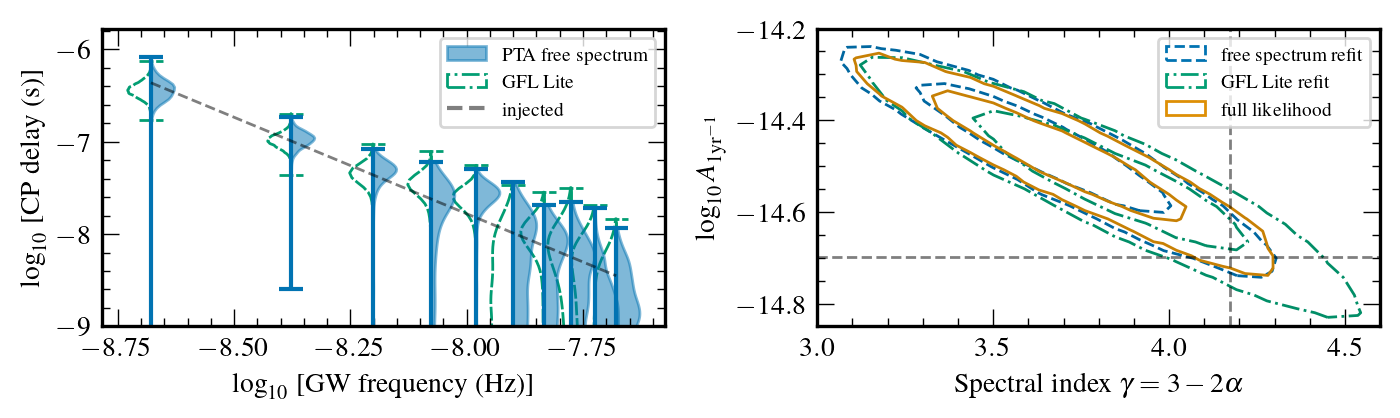

In [42]:
plt.show();

# Let's plot the 12.5yr data set results!

In [4]:
import h5py

In [5]:
# load published model2A (full like) chain
filename = '/data/taylor_group/william_lamb/analyses/NANOGrav/NANOGrav_12yv4/data/12p5yr_DE438_model2a_cRN5freq_gammaVary_chain.hdf5'
chain = h5py.File(filename, 'r')
m2a5f = co.Core(chain=chain['samples'][()], params=list(chain['params'][()].astype(np.unicode_)))

# free spec refit
dataset = '/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/freespec/30fCP_30fiRN_2A_wf/densities/'
pl5f = co.Core(dataset+'5fpl')

# gfl lite refit
gl5f = co.Core('/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/spsrs/30fCP_WNvary_wf/refits/5fpl')

/gpfs52/home/lambwg/la_forge/la_forge/core.py:179: UserWarning: loadtxt: Empty input file: "/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/freespec/30fCP_30fiRN_2A_wf/densities/5fpl/draw_from_gwb_loguni_dist_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)
/gpfs52/home/lambwg/la_forge/la_forge/core.py:179: UserWarning: loadtxt: Empty input file: "/data/taylor_group/william_lamb/analyses/NANOGrav/NG12p5/freespec/30fCP_30fiRN_2A_wf/densities/5fpl/draw_from_prior_jump.txt"
  self.jumps[ky] = np.loadtxt(path, dtype=float)


In [7]:
import seaborn as sns
colour = sns.color_palette('colorblind', as_cmap=True)

In [25]:
plt.rcParams["figure.figsize"] = [3.5503666805036667, 2.1942472810764047]

In [44]:
params = ['gamma_gw', 'log10_A_gw']
tex = ['$\gamma$', '$\log_{10}A$']

fig, ax = plt.subplots()

c = ChainConsumer()
c.add_chain(pl5f(params), parameters=tex, linestyle='--',
            name='free spectrum refit', color=colour[0])
c.add_chain(gl5f(params), name='GFL Lite', color=colour[2],
            linestyle='-.')
#c.add_chain(gfl5f(params), name='GFL', color=colour[2],
#            linestyle=':')
c.add_chain(m2a5f(['gw_gamma', 'gw_log10_A']),
            name='full likelihood', color=colour[3])
c.configure(usetex=False, sigmas=[1,2],
            shade_alpha=0, smooth=False,
            legend_kwargs={"loc": "upper right",
                           "frameon":False,
                           "facecolor":'white',
                           "fontsize":'medium',
                           'loc':'lower left'},
            linewidths=1,
            diagonal_tick_labels=False)
c.plotter.plot_contour(ax, *tex)

ax.set_xlim((3,7))
ax.set_ylim((-16.3, -14.2))

ax.axvline(13/3, ls='--', c='k', alpha=0.25)
ax.axhline(np.log10(1.9e-15), ls='--', c='k', alpha=0.25)

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\log_{10}A$')

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
c1 = mpatches.Patch(label='free spectrum refit', fill=False,
                    edgecolor=colour[0], linestyle='--')
c2 = mpatches.Patch(label='GFL Lite refit', fill=False, edgecolor=colour[2],
                    linestyle='-.')
c3 = mpatches.Patch(label='full likelihood', fill=False, edgecolor=colour[1],
                    linestyle='-')

ax.legend(handles=[c1, c2, c3], loc='upper right')

plt.savefig('../plots/12p5corner.pdf',
            dpi=400, bbox_inches='tight');

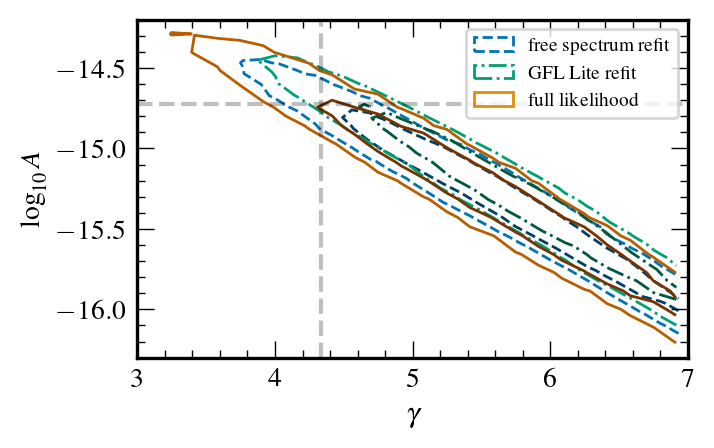

In [45]:
plt.show();